This work utilizes code from the **IntroMLLab** and **MAST-ML** modules available on NanoHub, as detailed below:

1. **Machine Learning Lab Module (IntroMLLab):**  
   [IntroMLLab on NanoHub](https://www.nanohub.org/resources/intromllab)

2. **Materials Simulation Toolkit for Machine Learning (MAST-ML):**  
   - [MAST-ML on NanoHub](https://www.nanohub.org/resources/mastmltutorial)  
   - [MAST-ML GitHub Repository](https://github.com/uw-cmg/MAST-ML)

In this work, we specifically import modules from **MAST-ML** to support our development.

In [3]:
pip install mastml pymatgen scikit-lego linear-tree gplearn cbfv deepchem duecredit

In [4]:
# MAST-ML imports for machine learning and feature engineering
from mastml.mastml import Mastml
from mastml.models import SklearnModel
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.data_splitters import SklearnDataSplitter  # Additional options: NoSplit, LeaveOutPercent
from mastml.feature_generators import ElementalFeatureGenerator  # Additional option: OneHotGroupGenerator
from mastml.hyper_opt import GridSearchCV  # Additional options: GridSearch, RandomizedSearch, BayesianSearch
from mastml.metrics import Metrics

# Standard library imports for data manipulation and time tracking
import os
import time
import random
from copy import copy
from collections import Counter

# Third-party library imports for data analysis and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.utils
from sklearn import tree
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split
import pymatgen

# Set random seed for reproducibility
seed = 12345123
np.random.seed(seed)
sklearn.utils.check_random_state(seed)


RandomState(MT19937) at 0x7E97147C5140

In [13]:
# Raw URL of the dataset
data_url = 'https://raw.githubusercontent.com/Adrita-Khan/BandGapAlign/main/data/citrination-export.csv'
mastml_df = pd.read_csv(data_url)  # Read dataset from the URL
mastml_df  # Display the dataframe

,Chemical formula,Band gap,Crystallinity,Color
0,Bi$_{2}$Te$_{3}$,0.153,Single crystalline,NaN
1,Mg$_{2}$Ge,0.567,Single crystalline,NaN
2,CoSi,0.045,Single crystalline,NaN
3,NaBr,7.025,Single crystalline,NaN
4,Ca$_{2}$Sn,0.9,Polycrystalline,NaN
...,...,...,...,...
1444,Te,0.334,Single crystalline,NaN
1445,NdTe$_{2}$,0.48,NaN,NaN
1446,Nb$_{2}$S$_{3}$,0.12,Polycrystalline,NaN
1447,TiS$_{2}$,1.95,Single crystalline,NaN


In [14]:
# Filter unnecessary or irrelevant columns and rows from the dataframe

# Drop the 'Color' column from the dataframe
mastml_df_filtered = mastml_df.drop(columns=['Color'])

# Uncomment one of the following lines to filter rows based on 'Crystallinity':
# Retain only rows where 'Crystallinity' is 'Single crystalline'
# mastml_df_filtered = mastml_df_filtered[mastml_df_filtered["Crystallinity"] == 'Single crystalline']

# Retain only rows where 'Crystallinity' is 'Polycrystalline'
# mastml_df_filtered = mastml_df_filtered[mastml_df_filtered["Crystallinity"] == 'Polycrystalline']

# Display the filtered dataframe
mastml_df_filtered


,Chemical formula,Band gap,Crystallinity
0,Bi$_{2}$Te$_{3}$,0.153,Single crystalline
1,Mg$_{2}$Ge,0.567,Single crystalline
2,CoSi,0.045,Single crystalline
3,NaBr,7.025,Single crystalline
4,Ca$_{2}$Sn,0.9,Polycrystalline
...,...,...,...
1444,Te,0.334,Single crystalline
1445,NdTe$_{2}$,0.48,NaN
1446,Nb$_{2}$S$_{3}$,0.12,Polycrystalline
1447,TiS$_{2}$,1.95,Single crystalline


In [15]:
# Convert 'Band gap' column to numeric, coercing errors to NaN to exclude rows with invalid values (e.g., containing ± sign)
mastml_df_filtered['Band gap'] = pd.to_numeric(mastml_df_filtered['Band gap'], errors='coerce')

# Optional: Uncomment the following line to explicitly handle rows with ± sign
# mastml_df_filtered = mastml_df_filtered.drop('Band gap', axis=1).join(
#     mastml_df_filtered['Band gap'].apply(pd.to_numeric, errors='coerce')
# )

# Clean 'Chemical formula' column by removing special characters (e.g., subscripts, superscripts, etc.)
mastml_df_filtered['Chemical formula'] = mastml_df_filtered['Chemical formula'].str.replace(r'[$_{}]', '', regex=True)

# Drop rows with missing (NaN) values across the dataframe
mastml_df_filtered = mastml_df_filtered.dropna()

# Display the cleaned dataframe
mastml_df_filtered


,Chemical formula,Band gap,Crystallinity
0,Bi2Te3,0.153,Single crystalline
1,Mg2Ge,0.567,Single crystalline
2,CoSi,0.045,Single crystalline
3,NaBr,7.025,Single crystalline
4,Ca2Sn,0.900,Polycrystalline
...,...,...,...
1442,PbI2,2.410,Single crystalline
1443,CdSb,0.450,Single crystalline
1444,Te,0.334,Single crystalline
1446,Nb2S3,0.120,Polycrystalline


In [16]:
# Filter and display rows where 'Band gap' contains NaN values (e.g., due to invalid entries like ± sign)
formulas_with_invalid_band_gap = mastml_df_filtered[mastml_df_filtered['Band gap'].isna()]

# Display the chemical formulas with invalid 'Band gap' entries
formulas_with_invalid_band_gap

,Chemical formula,Band gap,Crystallinity


In [17]:
# Remove any rows with NaN values, ensuring all formerly invalid entries (e.g., from regex or conversions) are excluded
mastml_df_clean = mastml_df_filtered.dropna()

# Display the cleaned dataframe
mastml_df_clean

,Chemical formula,Band gap,Crystallinity
0,Bi2Te3,0.153,Single crystalline
1,Mg2Ge,0.567,Single crystalline
2,CoSi,0.045,Single crystalline
3,NaBr,7.025,Single crystalline
4,Ca2Sn,0.900,Polycrystalline
...,...,...,...
1442,PbI2,2.410,Single crystalline
1443,CdSb,0.450,Single crystalline
1444,Te,0.334,Single crystalline
1446,Nb2S3,0.120,Polycrystalline


In [ ]:
# Options for filtering rows based on the 'Band gap' range
# Uncomment one or both of the following lines as needed:

# Remove rows where 'Band gap' is greater than 5.0
# mastml_df_clean = mastml_df_clean[mastml_df_clean['Band gap'] <= 5.0]

# Remove rows where 'Band gap' is less than 0.2
# mastml_df_clean = mastml_df_clean[mastml_df_clean['Band gap'] >= 0.2]

In [18]:
# Identify and list recurring compounds based on 'Chemical formula'
reoccurring_compounds = (
    mastml_df.groupby('Chemical formula')  # Group by 'Chemical formula'
    .filter(lambda group: len(group) > 1)  # Keep groups with more than one entry
    .drop_duplicates(subset=['Chemical formula', 'Band gap'], keep='first')  # Remove duplicate entries
    .sort_values(by='Chemical formula')  # Sort by 'Chemical formula'
)

# Display the resulting dataframe of recurring compounds
reoccurring_compounds

,Chemical formula,Band gap,Crystallinity,Color
1048,Ag$_{2}$O,1.591,Single crystalline,NaN
1161,Ag$_{2}$O,0.64,NaN,NaN
1059,Ag$_{2}$O,1.2,Polycrystalline,NaN
1382,Ag$_{2}$O,1.5,Polycrystalline,NaN
504,Ag$_{2}$S,1,Single crystalline,NaN
...,...,...,...,...
1033,ZrS$_{2}$,2.75,Single crystalline,NaN
474,ZrS$_{2}$,1.68,Single crystalline,Violet
798,ZrS$_{2}$,0.85,Polycrystalline,NaN
1265,ZrS$_{3}$,2.28,Single crystalline,Copper-Red


In [19]:
# Display column names in the DataFrame
print("Column names in the DataFrame:")
print(mastml_df_clean.columns)

# Remove any leading or trailing spaces from column names
mastml_df_clean.columns = mastml_df_clean.columns.str.strip()

# Check for the exact column name and calculate statistics for 'Band gap'
if "Band gap" in mastml_df_clean.columns:
    stats = mastml_df_clean["Band gap"].describe().round(3)
    print("Statistics for 'Band gap':")
    print(stats)
elif "Band Gap" in mastml_df_clean.columns:
    stats = mastml_df_clean["Band Gap"].describe().round(3)
    print("Statistics for 'Band Gap':")
    print(stats)
else:
    print("The column 'Band gap' or 'Band Gap' does not exist in the DataFrame.")


Column names in the DataFrame:
Index(['Chemical formula', 'Band gap', 'Crystallinity'], dtype='object')
Statistics for 'Band gap':
count    1258.000
mean        2.377
std         2.269
min         0.005
25%         0.820
50%         1.816
75%         3.000
max        13.600
Name: Band gap, dtype: float64


In [20]:
# Statistics for the band gap values in the data set
mastml_df_clean["Band gap"].describe().round(3)

,Band gap
count,1258.000
mean,2.377
std,2.269
min,0.005
25%,0.820
50%,1.816
75%,3.000
max,13.600


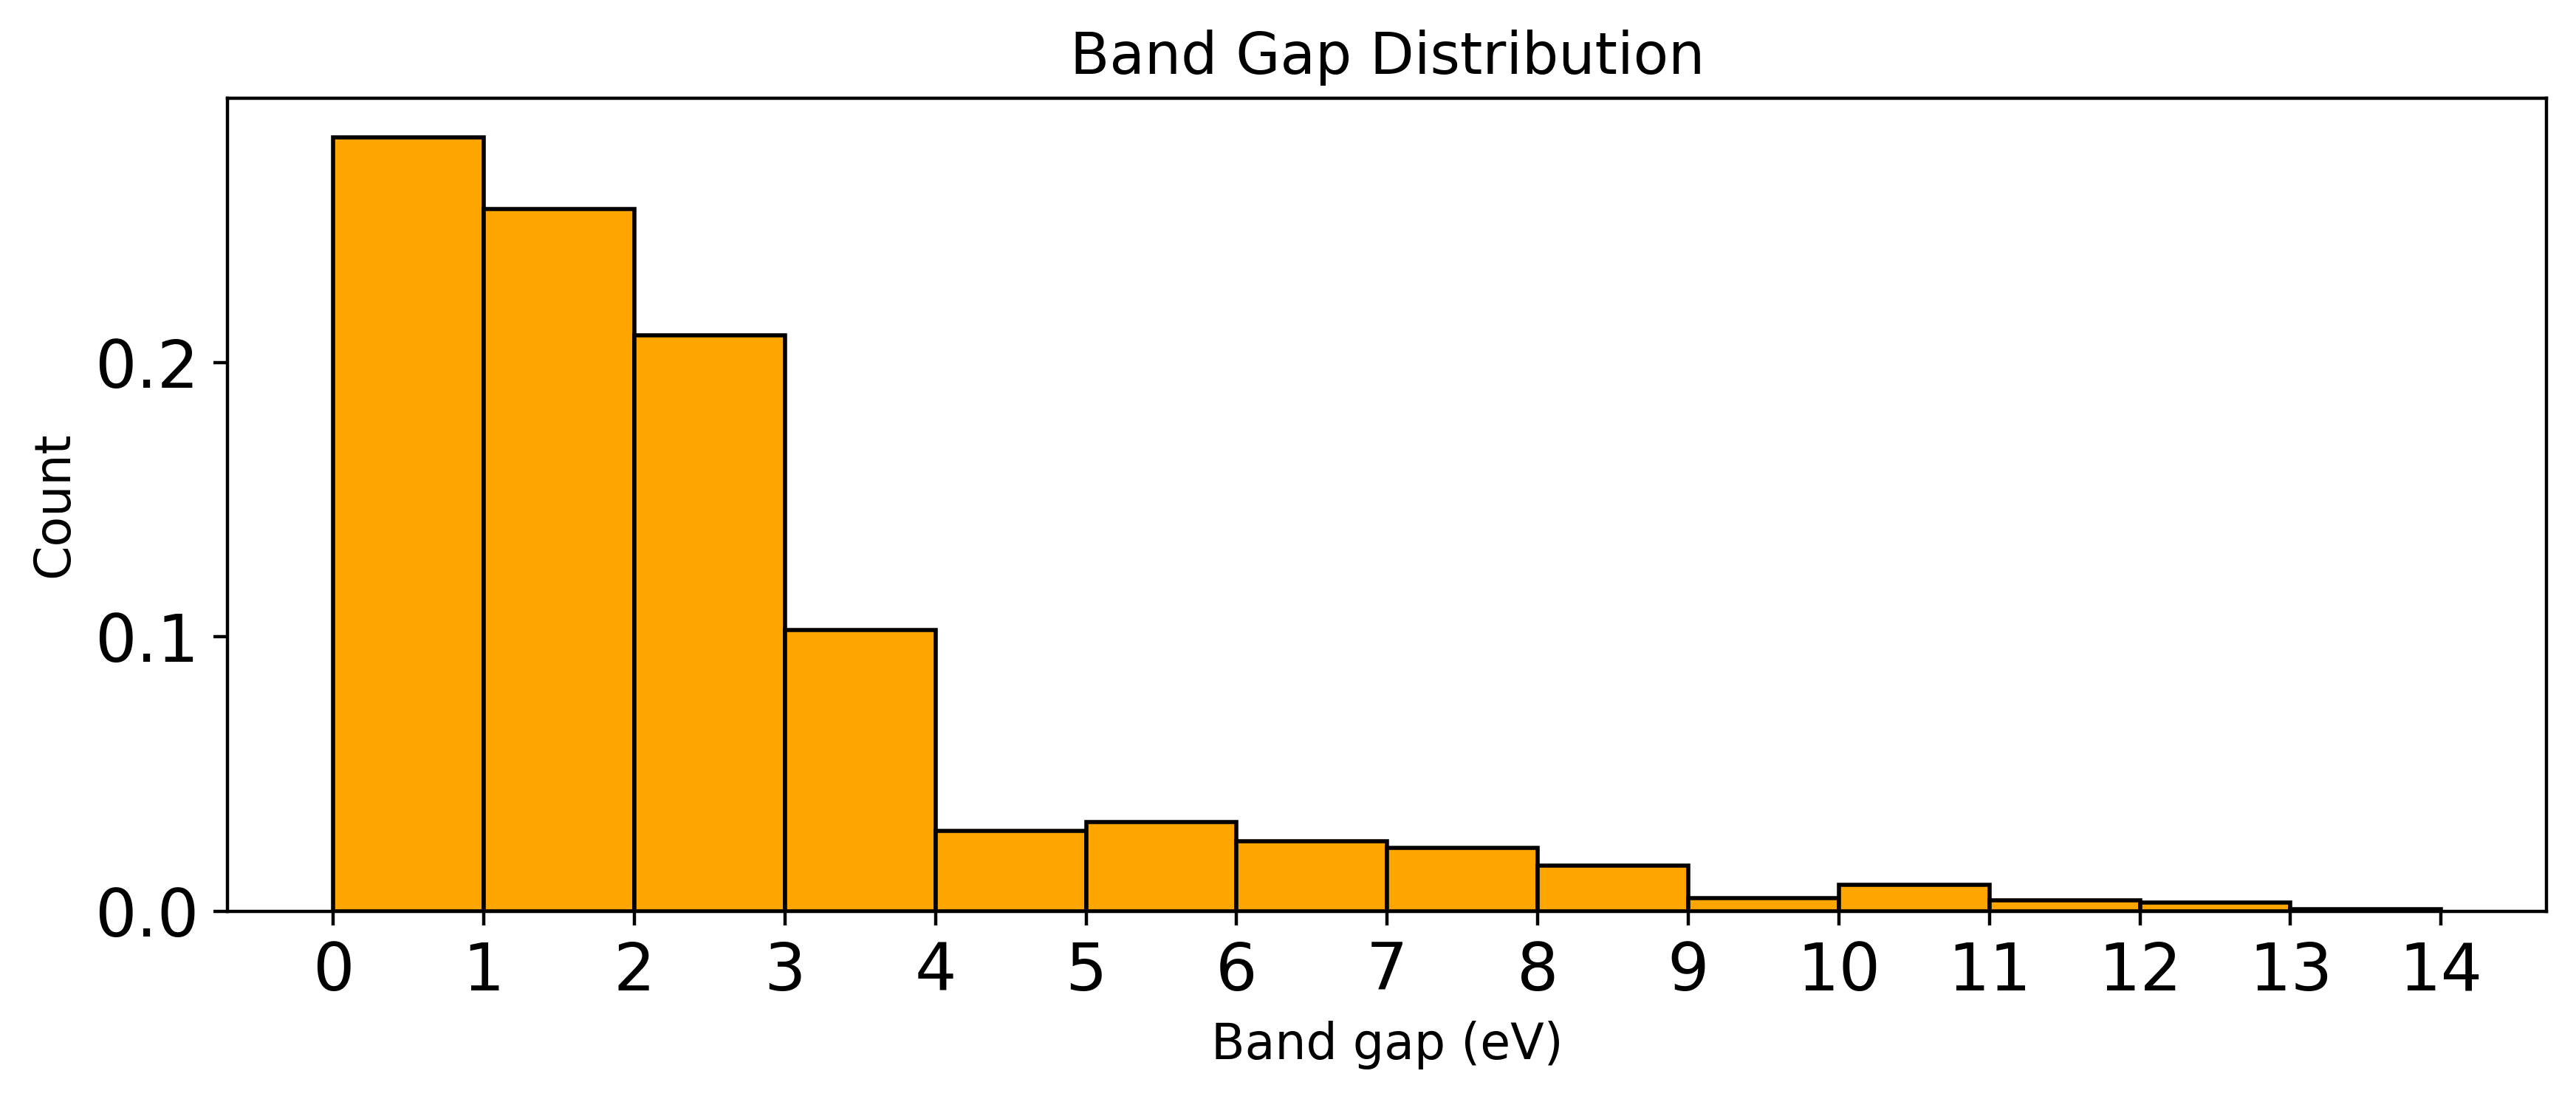

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def histogram_plot(data, bins_range=(0, 14), bin_width=1, color='orange', edge_color='black', title='Band Gap Distribution', xlabel='Band gap (eV)', ylabel='Count', figsize=(9, 4), dpi=400):
    """
    Plots a histogram for the provided data with customizable options.

    Parameters:
        data (pd.Series or array-like): Data to be plotted in the histogram.
        bins_range (tuple): Range for the histogram bins (default: (0, 14)).
        bin_width (int or float): Width of each bin (default: 1).
        color (str): Color of the bars (default: 'orange').
        edge_color (str): Color of the bar edges (default: 'black').
        title (str): Title of the plot (default: 'Band Gap Distribution').
        xlabel (str): Label for the x-axis (default: 'Band gap (eV)').
        ylabel (str): Label for the y-axis (default: 'Count').
        figsize (tuple): Figure size (default: (9, 4)).
        dpi (int): Dots per inch for the figure (default: 400).
    """

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Plot the histogram
    ax.hist(data, bins=np.arange(bins_range[0], bins_range[1] + bin_width, bin_width), density=True, color=color, edgecolor=edge_color, lw=1)

    # Set axis labels and title
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set x and y ticks based on the data range
    ax.set_xticks(np.arange(bins_range[0], bins_range[1] + bin_width, bin_width))
    ax.set_yticks(np.arange(0, ax.get_ylim()[1], 0.1))  # Dynamic y-ticks based on data

    # Show the plot
    plt.show()

# Example usage: Plot histogram of 'Band gap' column from a DataFrame
histogram_plot(mastml_df_filtered["Band gap"].astype("float"))


In [22]:
# Display unique 'Chemical formula' values in the cleaned DataFrame
unique_chemical_formulas = mastml_df_clean["Chemical formula"].unique()

# Print the unique chemical formulas
print("Unique Chemical Formulas:")
print(unique_chemical_formulas)

# Optionally, print the total count of unique formulas
print(f"Total unique chemical formulas: {len(unique_chemical_formulas)}")

Unique Chemical Formulas:
['Bi2Te3' 'Mg2Ge' 'CoSi' 'NaBr' 'Ca2Sn' 'As2S3' 'ZnO' 'Cu2Se' 'GeTe'
 'CaF2' 'Sb2Se3' 'InAs' 'CdI2' 'La2S3' 'Mg3Sb2' 'Cu2Te' 'PbTe' 'CaO'
 'Eu3As2' 'AgBr' 'ZnTe' 'ZrSe3' 'HgS' 'Cr2O3' 'GeSe2' 'LaB6' 'MgO' 'CdSb'
 'As2Se3' 'NaI' 'CdAs2' 'InSb' 'AlAs' 'As4S4' 'SmSe' 'CdO' 'Cu2S' 'SnCl2'
 'RbI' 'FeI2' 'C' 'HgI2' 'Ce2Se3' 'Eu2O3' 'RbCl' 'PbBr2' 'As2O3' 'SnBr2'
 'KI' 'SnO2' 'Pr2Se3' 'Mg2Sn' 'MnS' 'SnSe' 'MoO3' 'Ag2Te' 'TlBr' 'EuS'
 'Dy2S3' 'BiI3' 'EuTe' 'MgTe' 'Si' 'As2S5' 'AgCl' 'Te' 'Bi0.85Sb0.15'
 'Bi0.97Sb0.03' 'AlB' 'PbSe' 'MnF2' 'Ag2Se' 'TiSe2' 'Bi0.91Sb0.09' 'GaSb'
 'LiF' 'Sb2S3' 'GeS' 'V4O7' 'GaSe' 'CdTe' 'HgTe' 'ZrS3' 'Se' 'UO2' 'KBr'
 'GaAs' 'Fe2Te3' 'K3Sb' 'Bi2O3' 'GaS' 'Zn4Sb3' 'PdO' 'HgBr2' 'PtSb2'
 'PtAs2' 'NiS' 'La2Se3' 'Cr2S3' 'ZnS' 'GeO2' 'Sb2O3' 'ThO2' 'In2Se' 'ZnSb'
 'HfS3' 'Lu2O3' 'Sb0.71As0.29' 'Na3Sb' 'V2O5' 'Bi0.9Sb0.1' 'CeO2' 'PbS'
 'TiTe2' 'MoTe2' 'CaSe' 'OsSb2' 'In2Te3' 'Mg2Si' 'MnO' 'ReO3' 'Ta2O5'
 'PbO' 'InSe' 'Nb2O5' 'PrO2' 'B' 'Ca2Si' 

In [24]:
import re
from pymatgen.core.composition import Composition

# Function to clean chemical formulas
def clean_chemical_formula(formula):
    """
    Cleans the chemical formula by:
    - Replacing LaTeX-like subscript formatting ($_{}) with numeric subscripts.
    - Converting fractional compositions into a format parsable by pymatgen.
    """
    # Replace LaTeX-like subscript formatting ($_{...}$) with numeric subscripts
    cleaned_formula = re.sub(r'\$_\{([0-9.]+)\}\$', r'\1', formula)

    # Replace fractional subscripts in specific cases (e.g., Bi$_{0.85}$Sb$_{0.15}$ -> Bi0.85Sb0.15)
    cleaned_formula = re.sub(r'([A-Za-z]+)\$_\{([0-9.]+)\}\$', r'\1\2', cleaned_formula)
    return cleaned_formula

# Clean the "Chemical formula" column
mastml_df_clean["Chemical formula"] = mastml_df_clean["Chemical formula"].apply(clean_chemical_formula)

# Verify the cleaned formulas
print("Cleaned Chemical Formulas:")
print(mastml_df_clean["Chemical formula"].unique())

# Parse out individual elements using pymatgen's Composition parser
element_list = []
failed_formulas = []

for idx in mastml_df_clean.index:
    formula = mastml_df_clean.loc[idx, "Chemical formula"]
    try:
        # Parse the formula with pymatgen's Composition
        composition = Composition(formula)
        element_list.extend(composition.elements)  # Add elements to the list
    except Exception as e:
        # Log failed formulas for further inspection
        print(f"Failed to parse formula: {formula}, Error: {e}")
        failed_formulas.append(formula)

# Display the parsed elements
print("Parsed Elements:")
print(set(element_list))

# Display formulas that could not be parsed
if failed_formulas:
    print("\nFormulas that failed to parse:")
    print(failed_formulas)

Cleaned Chemical Formulas:
['Bi2Te3' 'Mg2Ge' 'CoSi' 'NaBr' 'Ca2Sn' 'As2S3' 'ZnO' 'Cu2Se' 'GeTe'
 'CaF2' 'Sb2Se3' 'InAs' 'CdI2' 'La2S3' 'Mg3Sb2' 'Cu2Te' 'PbTe' 'CaO'
 'Eu3As2' 'AgBr' 'ZnTe' 'ZrSe3' 'HgS' 'Cr2O3' 'GeSe2' 'LaB6' 'MgO' 'CdSb'
 'As2Se3' 'NaI' 'CdAs2' 'InSb' 'AlAs' 'As4S4' 'SmSe' 'CdO' 'Cu2S' 'SnCl2'
 'RbI' 'FeI2' 'C' 'HgI2' 'Ce2Se3' 'Eu2O3' 'RbCl' 'PbBr2' 'As2O3' 'SnBr2'
 'KI' 'SnO2' 'Pr2Se3' 'Mg2Sn' 'MnS' 'SnSe' 'MoO3' 'Ag2Te' 'TlBr' 'EuS'
 'Dy2S3' 'BiI3' 'EuTe' 'MgTe' 'Si' 'As2S5' 'AgCl' 'Te' 'Bi0.85Sb0.15'
 'Bi0.97Sb0.03' 'AlB' 'PbSe' 'MnF2' 'Ag2Se' 'TiSe2' 'Bi0.91Sb0.09' 'GaSb'
 'LiF' 'Sb2S3' 'GeS' 'V4O7' 'GaSe' 'CdTe' 'HgTe' 'ZrS3' 'Se' 'UO2' 'KBr'
 'GaAs' 'Fe2Te3' 'K3Sb' 'Bi2O3' 'GaS' 'Zn4Sb3' 'PdO' 'HgBr2' 'PtSb2'
 'PtAs2' 'NiS' 'La2Se3' 'Cr2S3' 'ZnS' 'GeO2' 'Sb2O3' 'ThO2' 'In2Se' 'ZnSb'
 'HfS3' 'Lu2O3' 'Sb0.71As0.29' 'Na3Sb' 'V2O5' 'Bi0.9Sb0.1' 'CeO2' 'PbS'
 'TiTe2' 'MoTe2' 'CaSe' 'OsSb2' 'In2Te3' 'Mg2Si' 'MnO' 'ReO3' 'Ta2O5'
 'PbO' 'InSe' 'Nb2O5' 'PrO2' 'B' 'Ca2Si'

In [25]:
def clean_and_parse_formula(formula):
    # Replace LaTeX-like subscript formatting with numeric subscripts
    formula = re.sub(r'\$_\{([0-9.]+)\}\$', r'\1', formula)

    # Handle fractional formulas, e.g., Bi0.85Sb0.15
    try:
        composition = Composition(formula)
        return composition.elements  # Return parsed elements
    except Exception as e:
        print(f"Failed to parse formula: {formula}, Error: {e}")
        return None  # Return None for invalid formulas

# Clean and parse formulas
parsed_elements = []
for idx, formula in enumerate(mastml_df_clean["Chemical formula"]):
    elements = clean_and_parse_formula(formula)
    if elements:
        parsed_elements.extend(elements)

# Unique parsed elements
print("Parsed Elements:")
print(set(parsed_elements))


Parsed Elements:
{Element Li, Element Be, Element B, Element C, Element N, Element O, Element F, Element Na, Element Mg, Element Al, Element Si, Element P, Element S, Element Cl, Element K, Element Ca, Element Sc, Element Ti, Element V, Element Cr, Element Mn, Element Fe, Element Co, Element Ni, Element Cu, Element Zn, Element Ga, Element Ge, Element As, Element Se, Element Br, Element Rb, Element Sr, Element Y, Element Zr, Element Nb, Element Mo, Element Ru, Element Pd, Element Ag, Element Cd, Element In, Element Sn, Element Sb, Element Te, Element I, Element Cs, Element Ba, Element La, Element Ce, Element Pr, Element Nd, Element Sm, Element Eu, Element Gd, Element Tb, Element Dy, Element Ho, Element Er, Element Tm, Element Yb, Element Lu, Element Hf, Element Ta, Element W, Element Re, Element Os, Element Pt, Element Hg, Element Tl, Element Pb, Element Bi, Element Th, Element U}


In [26]:
# setup a counter to count each element
temp_counter = Counter(element_list)
element_tuples = list(zip(list(temp_counter.keys()),list(temp_counter.values())))
element_df = pd.DataFrame(element_tuples,columns=["Element","Count"])
element_df_sorted = element_df.sort_values(by=["Count"],ascending=False)

In [27]:
element_df_sorted

,Element,Count
13,O,202
15,Se,178
11,S,171
1,Te,151
10,As,129
...,...,...
71,Y,2
72,Ho,2
55,Ta,1
52,Lu,1


In [28]:
data = mastml_df_clean['Chemical formula']
target = mastml_df_clean['Band gap']

In [29]:
feature_types = ['composition_avg','max', 'min', 'difference']
#feature_types = ['composition_avg', 'arithmetic_avg']
#feature_types = ['difference','max', 'min']
#feature_types = ['composition_avg']